In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import gc
import datatable as dt
from matplotlib.ticker import FuncFormatter
import dask.dataframe as dd
import warnings
warnings.filterwarnings("ignore")

# Load data and feature engineering

Python objects can be stored in the form of pickle files and pandas has inbuilt functions to read and write dataframes as pickle objects.

In [6]:
%%time
data = dt.fread("train.csv",fill=True).to_pandas()

CPU times: user 2min 8s, sys: 1min 39s, total: 3min 47s
Wall time: 2min 40s


In [7]:
%%time
data.to_pickle("riiid_train.pkl.gzip")
data = pd.read_pickle("riiid_train.pkl.gzip")

print("Train size:", data.shape)

Train size: (103272765, 10)
CPU times: user 1min 13s, sys: 2min 19s, total: 3min 33s
Wall time: 4min 54s


In [8]:
train = data[data['answered_correctly'] != -1]
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115.0,5692.0,0.0,1.0,3.0,1.0,NaN,NaN
1,1,56943,115.0,5716.0,0.0,2.0,2.0,1.0,37000.0,False
2,2,118363,115.0,128.0,0.0,0.0,0.0,1.0,55000.0,False
3,3,131167,115.0,7860.0,0.0,3.0,0.0,1.0,19000.0,False
4,4,137965,115.0,7922.0,0.0,4.0,1.0,1.0,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
103272760,47209474,8170093123,997266417.0,975.0,0.0,4093.0,0.0,0.0,39000.0,True
103272761,47209475,8170113957,997266417.0,1099.0,0.0,4094.0,0.0,0.0,48000.0,True
103272762,47209476,8170134118,997266417.0,987.0,0.0,4095.0,3.0,1.0,16000.0,True
103272763,47209477,8170174823,997266417.0,365.0,0.0,4096.0,3.0,0.0,15000.0,True


In [9]:
train.dtypes

row_id                              int32
timestamp                           int64
user_id                           float64
content_id                        float64
content_type_id                   float64
task_container_id                 float64
user_answer                       float64
answered_correctly                float64
prior_question_elapsed_time        object
prior_question_had_explanation     object
dtype: object

In [10]:
subset_id = train.groupby('user_id').agg({'answered_correctly':'count'}).reset_index().sample(frac=0.01, random_state=77)
subset_id

,user_id,answered_correctly
296558,1.620927e+09,1399
201059,1.101039e+09,92
325505,1.778561e+09,214
214834,1.175796e+09,566
227049,1.242430e+09,30
...,...,...
227704,1.245986e+09,75
203243,1.112915e+09,31
335989,1.835335e+09,92
45767,2.514576e+08,195


In [11]:
train = train[train['user_id'].isin(subset_id['user_id'])]
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
108296,108296,0,2280091.0,3955.0,0.0,0.0,0.0,0.0,NaN,NaN
108297,108297,38603,2280091.0,3678.0,0.0,1.0,1.0,1.0,31000.0,False
108298,108298,70610,2280091.0,8473.0,0.0,2.0,1.0,0.0,35000.0,False
108299,108299,112370,2280091.0,6372.0,0.0,3.0,0.0,1.0,29000.0,False
108300,108300,138211,2280091.0,214.0,0.0,4.0,1.0,1.0,38000.0,False
...,...,...,...,...,...,...,...,...,...,...
103248174,47184888,170410256,996898518.0,5284.0,0.0,12.0,0.0,0.0,13000.0,True
103248175,47184889,170436745,996898518.0,5453.0,0.0,13.0,3.0,0.0,7000.0,True
103248176,47184890,170452092,996898518.0,8420.0,0.0,14.0,0.0,0.0,16000.0,True
103248177,47184891,170465178,996898518.0,4511.0,0.0,15.0,3.0,0.0,7000.0,True


In [12]:
#update object datatypes to float for two columns:

train["prior_question_had_explanation"] = train["prior_question_had_explanation"].astype(str)
train = train[train['prior_question_had_explanation'] != "nan"]
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].map({'True': 1.0, 'False': 0.0})
train["prior_question_elapsed_time"] = train.prior_question_elapsed_time.astype(float)
train.dtypes
train.shape

(921807, 10)

In [13]:
del train['timestamp']  
del train['row_id']
del train['task_container_id']
del train['content_type_id']
gc.collect()

80

In [14]:
%%time
questions = pd.read_csv("questions.csv")
train_questions=train.merge(questions,left_on='content_id',right_on='question_id',how='left')
del questions
train_questions_gp=train_questions.groupby('question_id').agg({'answered_correctly':['mean','count','std']}).reset_index()
train_questions_gp.columns=['question_id','q_correct','q_count','q_std']
train_questions_gp.q_std = train_questions_gp.q_std.fillna(train_questions_gp.q_std.mean())

CPU times: user 1.24 s, sys: 238 ms, total: 1.47 s
Wall time: 445 ms


In [15]:
del train_questions
gc.collect()

20

In [16]:
train=train.merge(train_questions_gp,left_on='content_id',right_on='question_id',how='left')
del train_questions_gp

gc.collect()

20

In [17]:
user_flags = train.groupby('user_id').agg({'answered_correctly':['mean','count','min','max','std']}).reset_index()
user_flags.columns=['user_id','user_answer_mean','user_answer_count','user_min','user_max','user_std']
user_flags.user_std = user_flags.user_std.fillna(user_flags.user_std.mean())
user_flags.isnull().sum()
gc.collect()

20

In [18]:
train=train.merge(user_flags,on=['user_id'],how='left')
del user_flags
gc.collect()

20

In [19]:
#double checking size 
#train.index.size.compute()
train.shape

(921807, 15)

In [20]:
train.dtypes

user_id                           float64
content_id                        float64
user_answer                       float64
answered_correctly                float64
prior_question_elapsed_time       float64
prior_question_had_explanation    float64
question_id                         int64
q_correct                         float64
q_count                             int64
q_std                             float64
user_answer_mean                  float64
user_answer_count                   int64
user_min                          float64
user_max                          float64
user_std                          float64
dtype: object

In [21]:
train

,user_id,content_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,q_correct,q_count,q_std,user_answer_mean,user_answer_count,user_min,user_max,user_std
0,2280091.0,3678.0,1.0,1.0,31000.0,0.0,3678,0.705882,34,0.462497,0.485714,35,0.0,1.0,0.507093
1,2280091.0,8473.0,1.0,0.0,35000.0,0.0,8473,0.540741,135,0.500193,0.485714,35,0.0,1.0,0.507093
2,2280091.0,6372.0,0.0,1.0,29000.0,0.0,6372,0.478723,188,0.500881,0.485714,35,0.0,1.0,0.507093
3,2280091.0,214.0,1.0,1.0,38000.0,0.0,214,0.810945,201,0.392530,0.485714,35,0.0,1.0,0.507093
4,2280091.0,1300.0,0.0,1.0,23000.0,0.0,1300,0.782609,92,0.414731,0.485714,35,0.0,1.0,0.507093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921802,996898518.0,5284.0,0.0,0.0,13000.0,1.0,5284,0.837607,117,0.370397,0.437500,32,0.0,1.0,0.504016
921803,996898518.0,5453.0,3.0,0.0,7000.0,1.0,5453,0.681319,91,0.468547,0.437500,32,0.0,1.0,0.504016
921804,996898518.0,8420.0,0.0,0.0,16000.0,1.0,8420,0.224490,49,0.421570,0.437500,32,0.0,1.0,0.504016
921805,996898518.0,4511.0,3.0,0.0,7000.0,1.0,4511,0.648649,74,0.480651,0.437500,32,0.0,1.0,0.504016


# Preprocessing and Modeling

To improve model accuracy, we conduct following two pre-processing steps:


All the algorithms that use l1 or l2 norms require standardisation. It is also useful to standardise the data so that algorithms become less computational heavy.
To perform Feature selection, we choose a wrapper method,Recursive Forward Elimination.


We build a pipeline that streamlines the pre-processing steps and perform gridsearchcv to get the best model and parameters.

Run all features under gridsearch

In [21]:
%%time
#Preprocessing imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split #Splitting data for model training
from sklearn.metrics import roc_auc_score


X=train.loc[:,[ 'prior_question_elapsed_time',
       'prior_question_had_explanation','question_id','q_correct','q_count','q_std' ,'user_answer_mean',
    'user_answer_count', 'user_min', 'user_max', 'user_std']]#Selecting feature variables

Y=train['answered_correctly'] #Selecting the output columns
feature_list=X.columns

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,stratify=Y, random_state=1)

#arr = [LogisticRegression(),RandomForestClassifier(),xgboost.XGBClassifier()]

pipe = Pipeline([('RFE',RFE(xgboost.XGBClassifier())),('preprocessor',StandardScaler() ),
                ('Model',xgboost.XGBClassifier())])


grid_param = [
                {
                    
                    "RFE":[RFE(RandomForestClassifier())],
                    "Model":[RandomForestClassifier()],
                    "Model__n_estimators":[120,100],
                    "Model__criterion":['entropy'],
                    "Model__max_depth":[13,15,17],
                    "Model__oob_score":['True','False']
                },
                {   
                     "RFE":[RFE(LogisticRegression())],
                    "Model": [LogisticRegression()],
        
                 "Model__C": np.logspace(1, 1.5),
                 "Model__multi_class":['auto']
                 },
                {   
                 "RFE":[RFE(xgboost.XGBClassifier())],
                    "Model": [xgboost.XGBClassifier()],
                 }]

gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1,refit=True) # Fit grid search
best_model = gridsearch.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

Pipeline(memory=None,
         steps=[('RFE',
                 RFE(estimator=RandomForestClassifier(bootstrap=True,
                                                      class_weight=None,
                                                      criterion='gini',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators='warn',
                                                   

Let us print all the best features selected by the RFE method

In [23]:
init = [ 'prior_question_elapsed_time',
       'prior_question_had_explanation','question_id','q_correct','q_count','q_std' ,'user_answer_mean',
    'user_answer_count', 'user_min', 'user_max', 'user_std']
finalFeatureIndices = gridsearch.best_estimator_.named_steps["RFE"].get_support(indices=True)
finalFeatureList = [init[i] for i in finalFeatureIndices]
print(finalFeatureList)

['prior_question_elapsed_time', 'q_correct', 'q_std', 'user_answer_mean', 'user_std']


We can see from above, without the undersampling method is better

# Model Evaluation

Now, let us run best model on the selected features and evaluate accuracy with ROC score

In [22]:
%%time
#Preprocessing imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split #Splitting data for model training
from sklearn.metrics import roc_auc_score

# for model evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import confusion_matrix
%matplotlib inline
%matplotlib notebook

X=train.loc[:,['prior_question_elapsed_time', 'q_correct', 'q_std', 'user_answer_mean', 'user_std']]#Selecting feature variables

Y=train['answered_correctly'] #Selecting the output columns
feature_list=X.columns

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,stratify=Y, random_state=123)

pipe = Pipeline([('preprocessor',StandardScaler() ),
                ('Model',RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='entropy', max_depth=13,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=120, n_jobs=None,
                                        oob_score='True', random_state=None,
                                        verbose=0, warm_start=False))])

print('classification score for training data: ',np.mean(cross_val_score(pipe, X_train, y_train, cv=10)))
print('classification score for test data: ',np.mean(cross_val_score(pipe, X_test, y_test, cv=10)))

classifier = OneVsRestClassifier(pipe)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
y_pred = classifier.predict(X_test) #prelim
Y_test=np.asarray(y_test)

roc_prelim=roc_auc_score(np.asarray(y_test), y_pred)
roc=roc_auc_score(np.asarray(y_test), y_score[:, 1])
print("ROC : {:.5}".format(roc))

# Model Accuracy, how often is the classifier correct?
print("Test accuracy: ",metrics.accuracy_score(y_test, y_pred))

classification score for training data:  0.7255591914998546
classification score for test data:  0.7238259400436591
ROC : 0.76722
Test accuracy:  0.7258979616189887
CPU times: user 54min 57s, sys: 25.9 s, total: 55min 23s
Wall time: 28min 59s


Visualize ROC


<IPython.core.display.Javascript object>


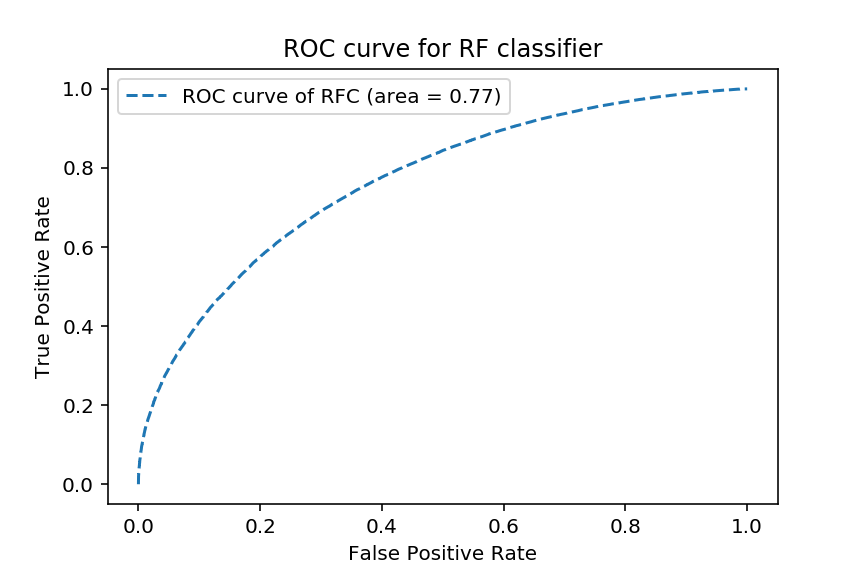


Classification Report

              precision    recall  f1-score   support

         0.0       0.65      0.44      0.53     63850
         1.0       0.75      0.88      0.81    120512

    accuracy                           0.73    184362
   macro avg       0.70      0.66      0.67    184362
weighted avg       0.72      0.73      0.71    184362


Confusion Matrix

[[ 28281  35569]
 [ 14965 105547]]


<IPython.core.display.Javascript object>


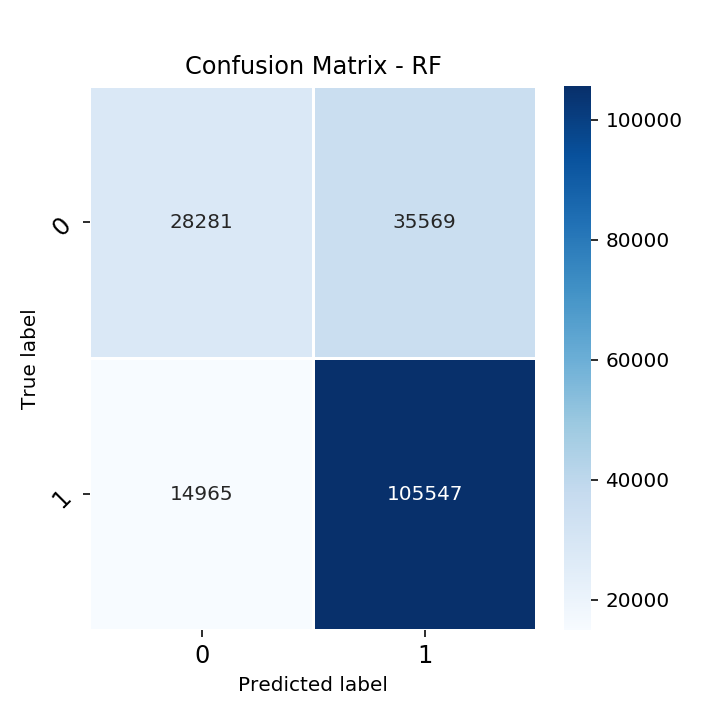

In [23]:
from sklearn.metrics import confusion_matrix
# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='ROC curve of RFC (area = {0:0.2f})'
             ''.format(roc))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.title('ROC curve for RF classifier')
plt.show()

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))

# build the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix\n')
print(cnf_matrix)

# plot resulting confusion matrix figure
fig, ax = plt.subplots(figsize=(5,5))
heatmap=sns.heatmap(cnf_matrix, linewidths=1,annot=True, fmt='',cmap='Blues')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45,  fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - RF')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Let's add the undersampling or oversampling method to pipeline to see if it improves model accuracy

In [24]:
imba_pipeline_test1 = Pipeline([('under', RandomUnderSampler()),('preprocessor',StandardScaler() ),
                ('Model',RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='entropy', max_depth=13,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=120, n_jobs=None,
                                        oob_score='True', random_state=None,
                                        verbose=0, warm_start=False))])
print('classification score for training data: ',np.mean(cross_val_score(imba_pipeline_test1, X_train, y_train, cv=10)))
print('classification score for test data: ',np.mean(cross_val_score(imba_pipeline_test1, X_test, y_test, cv=10)))


classification score for training data:  0.6908393247648628
classification score for test data:  0.6882491955123446


In [26]:
y_pred1 = imba_pipeline_test1.fit(X_train, y_train).predict(X_test) 
Y_test=np.asarray(y_test)
from sklearn.metrics import classification_report
print('\nClassification Report RandomUnderSampler method\n')
print(classification_report(y_test, y_pred1))


Classification Report RandomUnderSampler method

              precision    recall  f1-score   support

         0.0       0.54      0.70      0.61     63850
         1.0       0.81      0.69      0.75    120512

    accuracy                           0.69    184362
   macro avg       0.68      0.69      0.68    184362
weighted avg       0.72      0.69      0.70    184362



In [28]:
from imblearn.over_sampling import SMOTE
imba_pipeline_test2 = Pipeline([('smt', SMOTE()),('preprocessor',StandardScaler() ),
                ('Model',RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='entropy', max_depth=13,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=120, n_jobs=None,
                                        oob_score='True', random_state=None,
                                        verbose=0, warm_start=False))])
print('classification score for training data: ',np.mean(cross_val_score(imba_pipeline_test2, X_train, y_train, cv=10)))
print('classification score for test data: ',np.mean(cross_val_score(imba_pipeline_test2, X_test, y_test, cv=10)))



classification score for training data:  0.694331102677104
classification score for test data:  0.6926264325301789


In [30]:
y_pred2 = imba_pipeline_test2.fit(X_train, y_train).predict(X_test) 
Y_test=np.asarray(y_test)
from sklearn.metrics import classification_report
print('\nClassification Report SMOTE method\n')
print(classification_report(y_test, y_pred2))


Classification Report SMOTE method

              precision    recall  f1-score   support

         0.0       0.55      0.69      0.61     63850
         1.0       0.81      0.70      0.75    120512

    accuracy                           0.69    184362
   macro avg       0.68      0.69      0.68    184362
weighted avg       0.72      0.69      0.70    184362



From above, we see neither methods improved the model accuracy.

Testing the XGboost classifier with the hyperparameter from another run for comparison

In [75]:
%%time
#Preprocessing imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split #Splitting data for model training
from sklearn.metrics import roc_auc_score

# for model evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import confusion_matrix
%matplotlib inline
%matplotlib notebook

X=train.loc[:,['prior_question_elapsed_time', 'q_correct', 'user_answer_mean', 'user_answer_count', 'user_std']]#Selecting feature variables

Y=train['answered_correctly'] #Selecting the output columns
feature_list=X.columns

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,stratify=Y, random_state=123)

imba_pipeline = Pipeline([('preprocessor',StandardScaler() ),
                ('Model',xgboost.XGBClassifier(learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1,colsample_bytree=1, gamma=0))])

print('classification score for training data: ',np.mean(cross_val_score(imba_pipeline, X_train, y_train, cv=10)))
print('classification score for test data: ',np.mean(cross_val_score(imba_pipeline, X_test, y_test, cv=10)))

classifier = OneVsRestClassifier(imba_pipeline)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
y_pred = classifier.predict(X_test) #prelim
Y_test=np.asarray(y_test)

roc_prelim=roc_auc_score(np.asarray(y_test), y_pred)
roc=roc_auc_score(np.asarray(y_test), y_score[:, 1])
print("ROC : {:.5}".format(roc))

# Model Accuracy, how often is the classifier correct?
print("Test accuracy: ",metrics.accuracy_score(y_test, y_pred))

classification score for training data:  0.7265396037731711
classification score for test data:  0.7248999089544353
ROC : 0.76924
Test accuracy:  0.726619368416485
CPU times: user 12min 41s, sys: 1.39 s, total: 12min 42s
Wall time: 12min 13s


Testing the undersampling method

In [77]:
imba_pipeline_test = Pipeline([('under', RandomUnderSampler()),('preprocessor',StandardScaler() ),
                ('Model',xgboost.XGBClassifier(learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1,colsample_bytree=1, gamma=0))])
print('classification score for training data: ',np.mean(cross_val_score(imba_pipeline_test, X_train, y_train, cv=10)))
print('classification score for test data: ',np.mean(cross_val_score(imba_pipeline_test, X_test, y_test, cv=10)))


classification score for training data:  0.6933615431572382
classification score for test data:  0.689968624484242


<IPython.core.display.Javascript object>


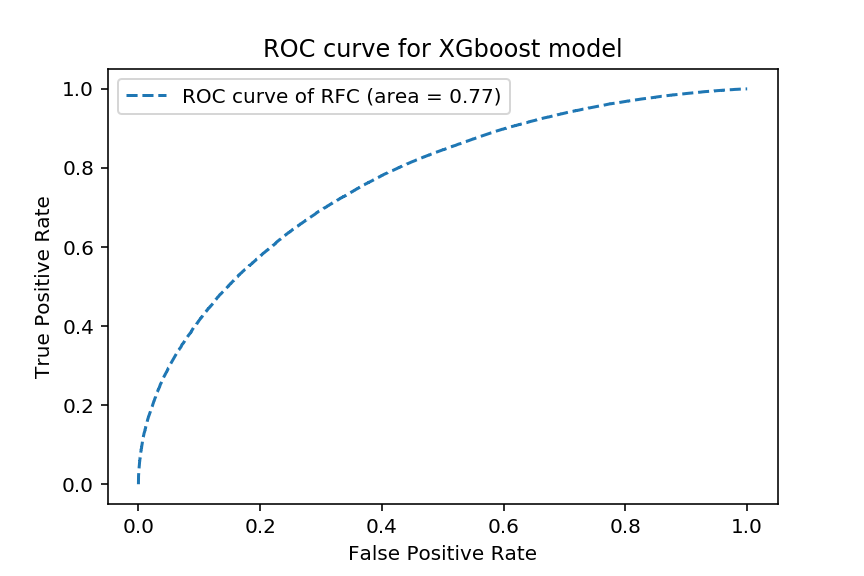


Classification Report

              precision    recall  f1-score   support

         0.0       0.65      0.45      0.53     63850
         1.0       0.75      0.87      0.81    120512

    accuracy                           0.73    184362
   macro avg       0.70      0.66      0.67    184362
weighted avg       0.72      0.73      0.71    184362


Confusion Matrix

[[ 28812  35038]
 [ 15363 105149]]


<IPython.core.display.Javascript object>


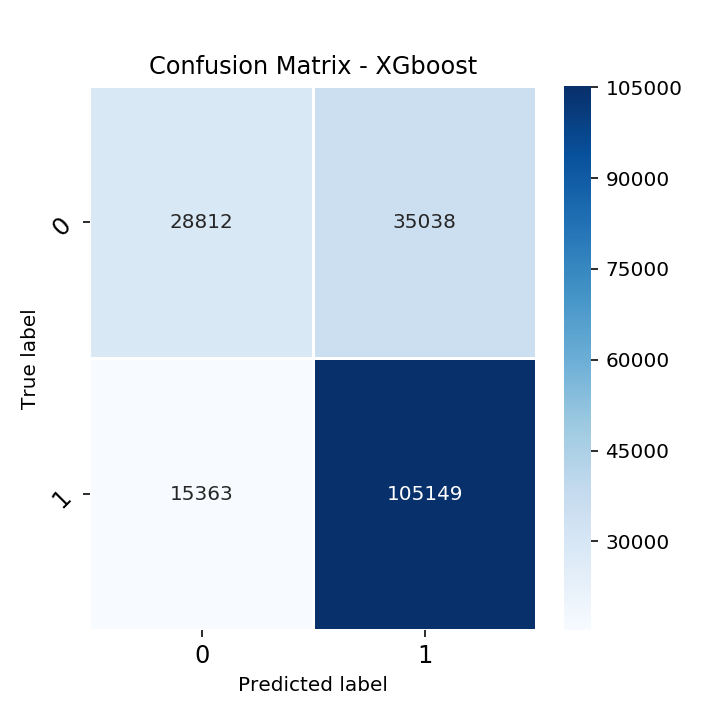

In [76]:
from sklearn.metrics import confusion_matrix
# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='ROC curve of RFC (area = {0:0.2f})'
             ''.format(roc))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.title('ROC curve for XGboost model')
plt.show()

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))

# build the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix\n')
print(cnf_matrix)

# plot resulting confusion matrix figure
fig, ax = plt.subplots(figsize=(5,5))
heatmap=sns.heatmap(cnf_matrix, linewidths=1,annot=True, fmt='',cmap='Blues')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45,  fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - XGboost')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Additionally adding SVM model with RGB kernel

In [ ]:
%%time
#Preprocessing imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from scipy import stats
from sklearn.model_selection import train_test_split #Splitting data for model training
from sklearn.metrics import roc_auc_score

X=train.loc[:,[ 'prior_question_elapsed_time', 'q_correct', 'q_std', 'user_answer_mean', 'user_std']]#Selecting feature variables

Y=train['answered_correctly'] #Selecting the output columns
feature_list=X.columns

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,stratify=Y, random_state=1)

imba_pipeline = Pipeline([('preprocessor',StandardScaler() ),
                ('Model',svm.SVC(probability = True, random_state = 1))])

param = {"Model": [OneVsRestClassifier(svm.SVC(kernel='rbf'))], #We cannot perform RFE on KNN
                 "Model__estimator__C":[0.1,10],
                 "Model__estimator__gamma":[0.1,1]
                 }


              
rand_search = RandomizedSearchCV(imba_pipeline, param_distributions = param,  n_jobs = -1, cv = 3) 
rand_search.fit(X_train,y_train) 
rand_search.cv_results_


print("The mean accuracy of the model is:",best_model.score(X_test,y_test))


